In [1]:
import tensorflow as tf
import numpy as np
from scipy.fft import dctn
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import clone_model
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from numpy.random import default_rng
from tensorflow.keras.models import load_model
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

In [2]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

In [3]:
train_images, test_images = train_images / 255.0, test_images / 255.0

In [4]:
N = 5  # Adjust this as needed

# Convert train_labels to a 1D array for easier manipulation
train_labels = train_labels.flatten()

# Initialize a list to hold the selected sets
unique_selections = []

# Iterate N times to generate N unique sets
for _ in range(N):
    selected_set = []
    used_indices = set()
    
    # Sample one image for each label (0 through 9)
    for label in range(10):
        # Find indices of all images with the current label
        label_indices = np.where(train_labels == label)[0]
        
        # Filter out indices that have been used in previous selections
        available_indices = list(set(label_indices) - used_indices)
        
        # Randomly choose one index from the available ones
        chosen_index = np.random.choice(available_indices)
        
        # Add the chosen index and image to the selection
        selected_set.append((train_images[chosen_index], train_labels[chosen_index]))
        
        # Mark the index as used
        used_indices.add(chosen_index)
    
    # Add the set of 10 images (one per label) to the unique selections list
    unique_selections.append(selected_set)

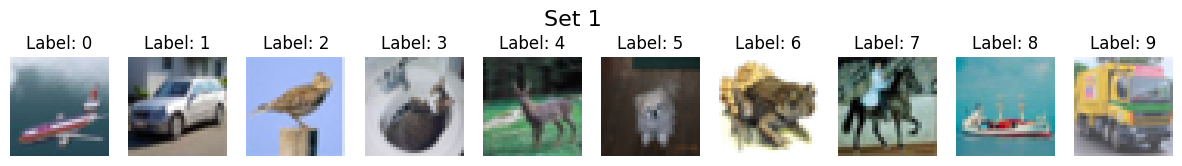

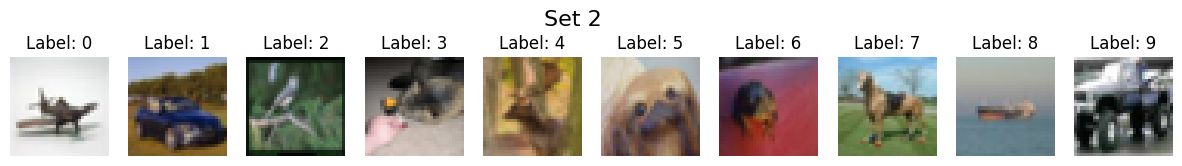

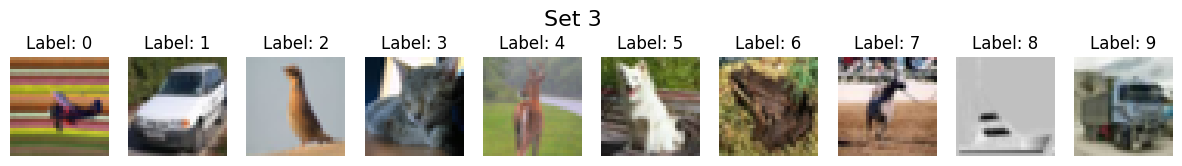

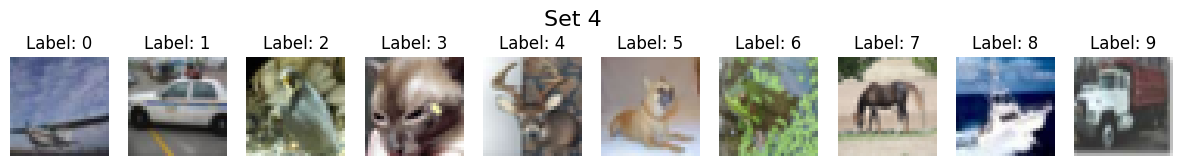

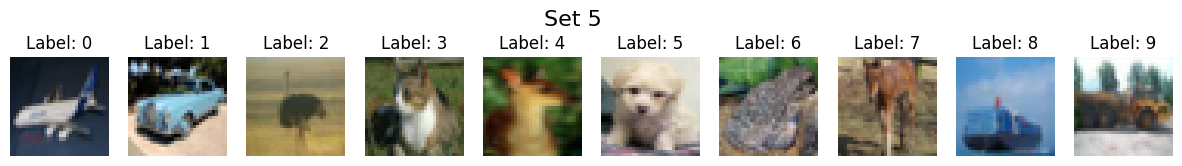

In [5]:
import matplotlib.pyplot as plt

# Function to visualize a set of images (one for each label)
def visualize_set(selected_set, set_index):
    fig, axes = plt.subplots(1, 10, figsize=(15, 2))
    fig.suptitle(f"Set {set_index + 1}", fontsize=16)
    for i, (image, label) in enumerate(selected_set):
        axes[i].imshow(image)
        axes[i].axis('off')
        axes[i].set_title(f"Label: {label}")

# Visualize each unique selection set
for i, selected_set in enumerate(unique_selections):
    visualize_set(selected_set, i)
    plt.show()


In [6]:
# Separate train images and labels from each selection set
all_images = []  # List to store images from each set
all_labels = []  # List to store labels from each set

for selected_set in unique_selections:
    images = [item[0] for item in selected_set]  # Extract images
    labels = [item[1] for item in selected_set]  # Extract labels
    all_images.append(images)
    all_labels.append(labels)

# Now, all_images[i] and all_labels[i] contain the images and labels of the i-th unique set.


In [7]:
all_labels[0]

[np.uint8(0),
 np.uint8(1),
 np.uint8(2),
 np.uint8(3),
 np.uint8(4),
 np.uint8(5),
 np.uint8(6),
 np.uint8(7),
 np.uint8(8),
 np.uint8(9)]

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [9]:
model = Sequential([
        Conv2D(32, (3,3), activation='relu', padding='same', kernel_initializer='he_normal', input_shape=(32,32,3), name='conv1'),
        Conv2D(32, (3,3), activation='relu', padding='same',kernel_initializer='he_normal', name='conv2'),
        MaxPooling2D((2,2), name='pool1'),
        Dropout(0.25),

        Conv2D(64, (3,3), activation='relu', padding='same',kernel_initializer='he_normal', name='conv3'),
        Conv2D(64, (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv4'),
        MaxPooling2D((2,2), name='pool2'),
        Dropout(0.25),

        Conv2D(128, (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv5'),
        Conv2D(128, (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv6'),
        MaxPooling2D((2,2), name='pool3'),
        Dropout(0.25),

        Conv2D(256, (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv7'),
        MaxPooling2D((2,2), name='pool4'),
        Dropout(0.25),
        #Conv2D(128, (3,3), activation='relu', padding='same', name='conv5'),
        Flatten(name='flatten'),
        Dense(128, activation='relu',kernel_initializer='he_normal', name='fc1'),
        Dense(64, activation='relu',kernel_initializer='he_normal', name='fc2'),
        Dense(10, activation='softmax', name='output')
        ])

/Users/amiruladlilhakim/Documents/VirtualEnv/tensorflow_env/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
model_copies = [tf.keras.models.clone_model(model) for _ in range(N)]

In [11]:
for i in range(N):
    model_copies[i].compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model_copies[i].fit(np.array(all_images[i]), np.array(all_labels[i]), epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.1250 - loss: 4.6953 - val_accuracy: 0.0000e+00 - val_loss: 5.5727
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.1250 - loss: 2.3708 - val_accuracy: 0.0000e+00 - val_loss: 5.0115
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.2500 - loss: 3.1668 - val_accuracy: 0.0000e+00 - val_loss: 4.5046
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.2500 - loss: 3.8428 - val_accuracy: 0.0000e+00 - val_loss: 3.7895
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.1250 - loss: 2.4029 - val_accuracy: 0.0000e+00 - val_loss: 3.4497
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.1250 - loss: 2.7015 - val_accuracy: 0.0000e+00 - val_loss: 3.1021
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.0000e+00 - loss: 2.5591 - val_accuracy: 0.0000e+00 - val_loss: 2.9575
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.3750 - loss: 2.1390 - val_accura

In [12]:

def get_filters(model, layer_name, filter_indices):
    layer = model.get_layer(name=layer_name)
    filters, biases = layer.get_weights()
    return filters[:, :, :, filter_indices]


def get_all_filters(model, layer_name):
    layer = model.get_layer(name=layer_name)
    filters, biases = layer.get_weights()
    return filters

In [13]:
def properties(model, layer_name, property_name):
    filter_norms = []
    filter_correlation = []
    feature_map_correlation = []
    feature_map_dct = []

    layer = model.get_layer(layer_name)
    filters, biases = layer.get_weights()
    num_filters = filters.shape[-1]

    if property_name == 'filter_norm':
        for i in range(num_filters):
            filt = filters[:, :, :, i]
            filt_matrix = filt.reshape(-1, filt.shape[-1])
            norm = np.linalg.norm(filt_matrix)
            filter_norms.append(norm)
        return filter_norms
    
    elif property_name == 'filter_correlation':
        for i in range(num_filters):
            filt = filters[:, :, :, i]
            filt_matrix = filt.reshape(-1, filt.shape[-1])
            uniqueness = np.linalg.norm(filt_matrix) - np.linalg.norm(get_all_filters(model, layer_name))
            filter_correlation.append(uniqueness)
        return filter_correlation
    
    elif property_name == 'feature_map_correlation':
        intermediate_model = models.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
        feature_maps = intermediate_model.predict(train_images[:1000])
        for i in range(num_filters):
            U, S, Vt = np.linalg.svd(feature_maps[:,:,:,i])
            feature_map_correlation.append(np.sum(S > 1e-5))
        return feature_map_correlation
    
    elif property_name == 'feature_map_dct':
        intermediate_model = models.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
        feature_maps = intermediate_model.predict(train_images[:1000])
        for i in range(num_filters):
            feature_map_dct.append(np.sqrt(np.sum(np.abs(dctn(feature_maps, norm='ortho')))) - np.sqrt(np.sum(np.abs(dctn(feature_maps[:,:,:,i], norm='ortho')))) )
        return feature_map_dct

In [14]:
def filter_to_keep(norms, percentage):
    threshold = np.percentile(norms, percentage)
    return [i for i, norm in enumerate(norms) if norm >= threshold]

In [15]:
def keep_filter_in_model(model):
    keep_filters ={}
    for layer in model.layers:
        if 'conv' in layer.name and layer.name != 'conv1' and layer.name != 'conv2':
            norms = properties(model, layer.name, 'filter_norm')
            keep_filters[layer.name] = filter_to_keep(norms, 95)
    return keep_filters

In [16]:
train_images.shape[1:]

(32, 32, 3)

In [17]:
keep_filter_in_model(model_copies[0])

{'conv3': [33, 48, 53, 55],
 'conv4': [18, 35, 48, 51],
 'conv5': [14, 47, 65, 86, 89, 107, 127],
 'conv6': [0, 13, 22, 59, 65, 73, 112],
 'conv7': [31, 82, 83, 114, 124, 140, 150, 177, 180, 193, 211, 241, 250]}

In [18]:
def dict_keep_filters_in_model(model_list):
    dict_keep_filters = {}
    for i, model in enumerate(model_list):
        dict_keep_filters[i] = keep_filter_in_model(model)
    return dict_keep_filters

In [19]:
model_dict = dict_keep_filters_in_model(model_copies)

In [20]:
def get_var_name(var):
    for name, value in locals().items():
        if value is var:
            return name

def copy_weights_pruned(source_model, pruned_target_model, source_layer_names, target_layer_names, keep_filters):
    for source_layer, target_layer in zip(source_model.layers, pruned_target_model.layers):
        if isinstance(source_layer, tf.keras.layers.Conv2D) and source_layer.name not in source_layer_names and target_layer.name not in target_layer_names:
            w, b = source_layer.get_weights()
            target_layer.set_weights([w, b])
        elif source_layer.name in source_layer_names and target_layer.name in target_layer_names:
            for keep_filt in keep_filters:
                if source_layer.name in get_var_name(keep_filt):
                    w, b = source_layer.get_weights()
                    target_layer.set_weights([w[:, :, :, keep_filt], b[keep_filt]])

In [21]:
def change_filters(model, layer_names, new_filter_count):
    new_layers = []
    for layer in model.layers:
        if layer.name in layer_names and isinstance(layer, Conv2D):
            # Get the existing configuration and change the filter count
            config = layer.get_config()
            config['filters'] = new_filter_count
            # Recreate the layer with the new filter count
            new_layer = Conv2D.from_config(config)
            new_layers.append(new_layer)
        else:
            # Keep the original layer if it doesn't match the criteria
            new_layers.append(layer)
    
    # Rebuild the model with the modified layers
    new_model = Sequential(new_layers)
    return new_model

In [22]:
list(model_dict[0].keys())[0]

'conv3'

In [23]:
list(model_dict[0].values())[0]

[33, 48, 53, 55]

In [24]:
def build_pruned_models(model_list, model_dict):
    pruned_models = []
    for i in model_dict:
        pruned_model = Sequential([
        Conv2D(32, (3,3), activation='relu', padding='same',kernel_initializer='he_normal', input_shape=(32,32,3), name='conv1'),
        Conv2D(32, (3,3), activation='relu', padding='same',kernel_initializer='he_normal', name='conv2'),
        MaxPooling2D((2,2), name='pool1'),
        Dropout(0.25),

        Conv2D(len(model_dict[i]['conv3']), (3,3), activation='relu', padding='same',kernel_initializer='he_normal', name='conv3'),
        Conv2D(len(model_dict[i]['conv4']), (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv4'),
        MaxPooling2D((2,2), name='pool2'),
        Dropout(0.25),

        Conv2D(len(model_dict[i]['conv5']), (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv5'),
        Conv2D(len(model_dict[i]['conv6']), (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv6'),
        MaxPooling2D((2,2), name='pool3'),
        Dropout(0.25),

        Conv2D(len(model_dict[i]['conv7']), (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv7'),
        MaxPooling2D((2,2), name='pool4'),
        Dropout(0.25),
        #Conv2D(128, (3,3), activation='relu', padding='same', name='conv5'),
        Flatten(name='flatten'),
        Dense(len(model_dict[i]['conv7']), activation='relu',kernel_initializer='he_normal', name='fc1'),
        Dense(64, activation='relu',kernel_initializer='he_normal', name='fc2'),
        Dense(10, activation='softmax', name='output')
        ])

        copy_weights_pruned(model_list[i], pruned_model, list(model_dict[i].keys()), list(model_dict[i].keys()), model_dict[i].values())
        pruned_models.append(pruned_model)
    return pruned_models
        

In [25]:
pruned_models = build_pruned_models(model_copies, model_dict)

In [26]:
pruned_models[0].summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 16, 16, 4)      │         1,156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4 (Conv2D)                  │ (None, 16, 16, 4)      │           148 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 8, 8, 4)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 8, 8, 4)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv5 (Conv2D)                  │ (None, 8, 8, 7)        │           259 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv6 (Conv2D)                  │ (None, 8, 8, 7)        │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 4, 4, 7)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 4, 4, 7)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv7 (Conv2D)                  │ (None, 4, 4, 13)       │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool4 (MaxPooling2D)            │ (None, 2, 2, 13)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 2, 2, 13)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 52)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 13)             │           689 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 64)             │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,222 (59.46 KB)

 Trainable params: 15,222 (59.46 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
model_copies[0].summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4 (Conv2D)                  │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv5 (Conv2D)                  │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv6 (Conv2D)                  │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv7 (Conv2D)                  │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool4 (MaxPooling2D)            │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,166,848 (8.27 MB)

 Trainable params: 722,282 (2.76 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,444,566 (5.51 MB)

In [28]:
# doesnt work yet

def build_pruned_models2(model_list, model_dict):
    pruned_models = []
    for i in model_dict:
        pruned_model = tf.keras.models.clone_model(model_list[i])
        for j in range(len(model_dict[i])):
            change_filters(pruned_model, list(model_dict[i].keys())[j], len(list(model_dict[i].values())[j]))            
        pruned_models.append(pruned_model)
    return pruned_models


In [29]:
def survived_filters_per_layer(model_dict, model_copies):
    survived_filters = {}
    for i in model_dict[0].keys():
        filters = {}
        for j in model_dict:
            filters[j] = get_filters(model_copies[j], i, model_dict[j][i])
        survived_filters[i] = filters
    return survived_filters 

def survived_filters_per_layer_indexes(model_dict):
    survived_filters = {}
    for i in model_dict[0].keys():
        filters = {}
        for j in model_dict:
           filters[j] = model_dict[j][i]
        survived_filters[i] = filters
    return survived_filters

survived_filters = survived_filters_per_layer(model_dict, model_copies)
survived_filters_indexes = survived_filters_per_layer_indexes(model_dict)

In [30]:
survived_filters['conv7'][3][:, :, :, 0] # survived filter in the 3 copied model, conv7 layer, the first filter (filter 0)

array([[[-0.07134242,  0.03340964,  0.05879077, ...,  0.02316565,
         -0.04083106, -0.01483687],
        [-0.02487146, -0.0434021 , -0.03337761, ...,  0.0580379 ,
          0.0076218 ,  0.02975206],
        [-0.02718271,  0.05769626,  0.04945996, ...,  0.06357908,
         -0.02802876, -0.02184677]],

       [[ 0.01750554, -0.04545448,  0.0477474 , ...,  0.01408415,
         -0.01659943, -0.02862716],
        [-0.02744132, -0.02415339, -0.07295945, ...,  0.0321149 ,
          0.03585817,  0.00925198],
        [ 0.01495709, -0.01257409, -0.007329  , ...,  0.02515136,
         -0.017704  ,  0.01329989]],

       [[ 0.08398356, -0.01306858, -0.03056379, ...,  0.0122425 ,
         -0.00050485,  0.01915025],
        [ 0.00038092, -0.05540504, -0.01569042, ..., -0.05924004,
         -0.08727826, -0.02523073],
        [-0.0011222 , -0.04154931,  0.07056428, ...,  0.01349815,
         -0.0177969 , -0.00511852]]], dtype=float32)

In [31]:
survived_filters_indexes['conv7'][3] # survived filter indexes in the 3 copied model, conv7 layer

[23, 81, 95, 98, 136, 159, 172, 173, 177, 178, 194, 227, 237]

In [32]:
survived_filters_indexes

{'conv3': {0: [33, 48, 53, 55],
  1: [2, 8, 26, 57],
  2: [13, 29, 46, 53],
  3: [8, 19, 26, 57],
  4: [13, 24, 50, 51]},
 'conv4': {0: [18, 35, 48, 51],
  1: [22, 25, 39, 49],
  2: [13, 24, 35, 46],
  3: [43, 56, 58, 59],
  4: [0, 12, 35, 43]},
 'conv5': {0: [14, 47, 65, 86, 89, 107, 127],
  1: [21, 34, 41, 51, 58, 70, 104],
  2: [0, 11, 32, 37, 92, 108, 113],
  3: [23, 60, 68, 71, 79, 99, 107],
  4: [16, 27, 33, 41, 64, 83, 84]},
 'conv6': {0: [0, 13, 22, 59, 65, 73, 112],
  1: [4, 9, 45, 70, 96, 117, 118],
  2: [3, 27, 58, 72, 93, 102, 109],
  3: [18, 24, 34, 42, 97, 113, 126],
  4: [20, 42, 46, 56, 96, 113, 124]},
 'conv7': {0: [31, 82, 83, 114, 124, 140, 150, 177, 180, 193, 211, 241, 250],
  1: [27, 79, 92, 125, 136, 151, 156, 182, 196, 203, 204, 236, 249],
  2: [42, 51, 67, 76, 84, 106, 132, 139, 146, 201, 220, 232, 247],
  3: [23, 81, 95, 98, 136, 159, 172, 173, 177, 178, 194, 227, 237],
  4: [13, 27, 40, 55, 76, 91, 137, 183, 189, 199, 208, 217, 224]}}

In [33]:
def filter_batch_index(survived_filter_indexes):
    filter_batch_indexes = {}
    for i in survived_filters_indexes.keys():
        filter_batch_indexes[i] = sorted({item for sublist in survived_filters_indexes[i].values() for item in sublist})
    return filter_batch_indexes

    

In [34]:
batch_indexes = filter_batch_index(survived_filters_indexes)

In [35]:
model_dict

{0: {'conv3': [33, 48, 53, 55],
  'conv4': [18, 35, 48, 51],
  'conv5': [14, 47, 65, 86, 89, 107, 127],
  'conv6': [0, 13, 22, 59, 65, 73, 112],
  'conv7': [31, 82, 83, 114, 124, 140, 150, 177, 180, 193, 211, 241, 250]},
 1: {'conv3': [2, 8, 26, 57],
  'conv4': [22, 25, 39, 49],
  'conv5': [21, 34, 41, 51, 58, 70, 104],
  'conv6': [4, 9, 45, 70, 96, 117, 118],
  'conv7': [27, 79, 92, 125, 136, 151, 156, 182, 196, 203, 204, 236, 249]},
 2: {'conv3': [13, 29, 46, 53],
  'conv4': [13, 24, 35, 46],
  'conv5': [0, 11, 32, 37, 92, 108, 113],
  'conv6': [3, 27, 58, 72, 93, 102, 109],
  'conv7': [42, 51, 67, 76, 84, 106, 132, 139, 146, 201, 220, 232, 247]},
 3: {'conv3': [8, 19, 26, 57],
  'conv4': [43, 56, 58, 59],
  'conv5': [23, 60, 68, 71, 79, 99, 107],
  'conv6': [18, 24, 34, 42, 97, 113, 126],
  'conv7': [23, 81, 95, 98, 136, 159, 172, 173, 177, 178, 194, 227, 237]},
 4: {'conv3': [13, 24, 50, 51],
  'conv4': [0, 12, 35, 43],
  'conv5': [16, 27, 33, 41, 64, 83, 84],
  'conv6': [20, 42, 4

In [49]:
def build_pruned_model(model, batch_indexes):
    pruned_model = Sequential([
        Conv2D(32, (3,3), activation='relu', padding='same',kernel_initializer='he_normal', input_shape=(32,32,3), name='conv1'),
        Conv2D(32, (3,3), activation='relu', padding='same',kernel_initializer='he_normal', name='conv2'),
        MaxPooling2D((2,2), name='pool1'),
        Dropout(0.25),

        Conv2D(len(batch_indexes['conv3']), (3,3), activation='relu', padding='same',kernel_initializer='he_normal', name='conv3'),
        Conv2D(len(batch_indexes['conv4']), (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv4'),
        MaxPooling2D((2,2), name='pool2'),
        Dropout(0.25),

        Conv2D(len(batch_indexes['conv5']), (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv5'),
        Conv2D(len(batch_indexes['conv6']), (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv6'),
        MaxPooling2D((2,2), name='pool3'),
        Dropout(0.25),

        Conv2D(len(batch_indexes['conv7']), (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv7'),
        MaxPooling2D((2,2), name='pool4'),
        Dropout(0.25),
        #Conv2D(128, (3,3), activation='relu', padding='same', name='conv5'),
        Flatten(name='flatten'),
        Dense(len(batch_indexes['conv7']), activation='relu',kernel_initializer='he_normal', name='fc1'),
        Dense(64, activation='relu',kernel_initializer='he_normal', name='fc2'),
        Dense(10, activation='softmax', name='output')
        ])

    copy_weights_pruned(model, pruned_model, list(batch_indexes.keys()), list(batch_indexes.keys()), batch_indexes.values())
    return pruned_model

In [50]:
pruned_model = build_pruned_model(model, batch_indexes)

/Users/amiruladlilhakim/Documents/VirtualEnv/tensorflow_env/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [51]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4 (Conv2D)                  │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv5 (Conv2D)                  │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv6 (Conv2D)                  │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv7 (Conv2D)                  │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool4 (MaxPooling2D)            │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 722,282 (2.76 MB)

 Trainable params: 722,282 (2.76 MB)

 Non-trainable params: 0 (0.00 B)

In [52]:
pruned_model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 16, 16, 15)     │         4,335 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4 (Conv2D)                  │ (None, 16, 16, 17)     │         2,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 8, 8, 17)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 8, 8, 17)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv5 (Conv2D)                  │ (None, 8, 8, 33)       │         5,082 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv6 (Conv2D)                  │ (None, 8, 8, 32)       │         9,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv7 (Conv2D)                  │ (None, 4, 4, 61)       │        17,629 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool4 (MaxPooling2D)            │ (None, 2, 2, 61)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 2, 2, 61)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 244)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 61)             │        14,945 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 64)             │         3,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,601 (267.97 KB)

 Trainable params: 68,601 (267.97 KB)

 Non-trainable params: 0 (0.00 B)